In [2]:
%load_ext autoreload
%autoreload 1

In [22]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from scipy import stats
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import sys
sys.path.append('../../src')
from data import fetch_model_data
from model import evaluation
%aimport data.fetch_model_data
%aimport model.evaluation

# EDA On Normal Set

In [5]:
metrics=['roc_auc', 'accuracy', 'precision']

## Load Data

In [6]:
ip_address = '18.218.116.177'
_, normal_data = fetch_model_data.fetch_model_data(ip_address, split=True)

In [7]:
first_feature_set = [
    'author_ideology',
    'author_party',
    'author_is_chair',
    'author_years_sen',
    'author_total_funding',
    'total_sponsors',
    'sponsor_chairs',
    'agg_funding_sponsors',
    'agg_exp_sponsors',
    'total_slips',
    'slips_perc_pro',
    'bipartisan',
    'ideol_range',
#     'first_word_approp',
]

In [8]:
X, y = normal_data[first_feature_set], normal_data.third_reading
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)

# Basic Eda

In [13]:
normal_data.third_reading.value_counts()

1    721
0    132
Name: third_reading, dtype: int64

<BarContainer object of 2 artists>

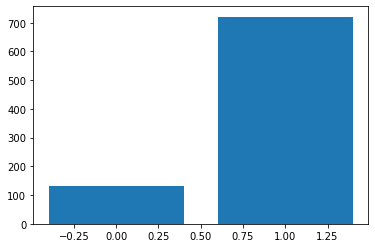

In [14]:
plt.bar([1, 0], normal_data.third_reading.value_counts())

In [15]:
normal_data.third_reading.value_counts()[1] / normal_data.shape[0]
# 85% of the data is class 1 (gets a third reading)

0.8452520515826495

In [17]:
by_author = normal_data.groupby('author_id').third_reading.agg(['sum', 'count']).reset_index()
by_author['perc_third'] = by_author['sum'] / by_author['count']

In [ ]:
by_author.sort_values('perc_third')
# No crazy outliers


# Histograms

In [11]:
def print_histograms(data, features, kde=True, y_lim=None):
    fig, ax = plt.subplots(nrows=len(features))

    fig.set_figheight(6*len(features))
    for a, col in zip(ax, features):
        
        sns.distplot(data[data.third_reading == 0][col], label='No', ax=a, kde=kde)
        sns.distplot(data[data.third_reading == 1][col], label='Yes', ax=a, kde=kde)       
        if y_lim:
            a.set_ylim([0, y_lim])
        a.set_title(col)
        a.legend()


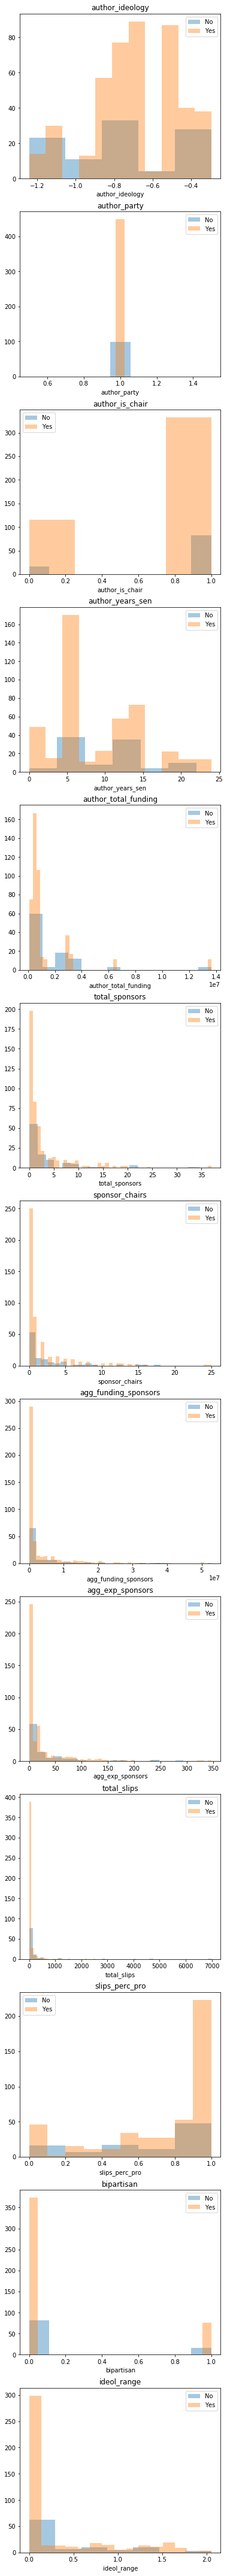

In [21]:
print_histograms(normal_data[normal_data.author_party == 1], first_feature_set, kde=False)

# With Oversampling

In [15]:
ros = RandomOverSampler(random_state=0)
normal_os, tr_os = ros.fit_sample(normal_data.drop(columns=['third_reading']), normal_data['third_reading'])
normal_os = pd.DataFrame(normal_os, columns=[x for x in normal_data.columns if x != 'third_reading'])
normal_os['third_reading'] = tr_os

In [16]:
normal_os.third_reading.value_counts()

1    721
0    721
Name: third_reading, dtype: int64

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


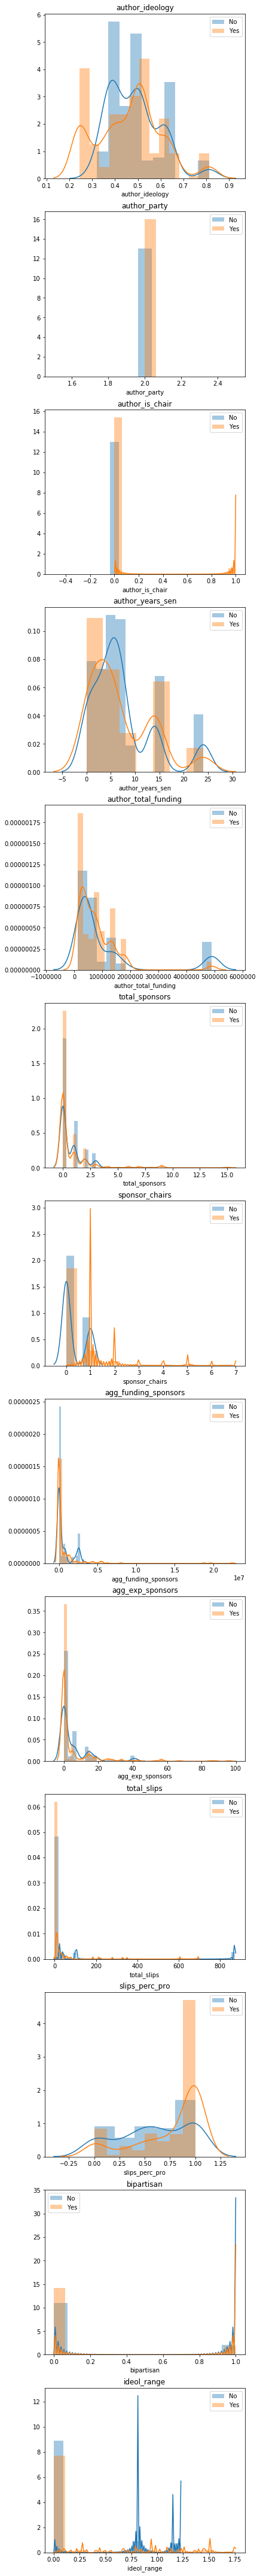

In [20]:
print_histograms(normal_os[normal_os.author_party == 2], first_feature_set, kde=True)

In [ ]:
# risk metric
    # less risky: new, minority party, high-funding (competative race)

In [1]:
author_features = [
    'author_ideology',
    'author_party',
    'author_is_chair',
    'author_years_sen',
    'author_total_funding',
    'third_reading'
]

sns.pairplot(normal_os[normal_os.author_party == 2][author_features], hue='third_reading', plot_kws={'alpha': 0.1})

NameError: name 'sns' is not defined

In [84]:
normal_data.author_years_sen.value_counts()

5.0     241
14.0    160
2.0      78
0.0      59
11.0     52
9.0      42
6.0      37
7.0      23
24.0     21
4.0      20
18.0     20
20.0     17
13.0     14
22.0     14
3.0      14
8.0      13
1.0      12
19.0     11
15.0      5
Name: author_years_sen, dtype: int64

# New Features

## Risk Tolerance

In [56]:
fe = normal_os.copy()
fe = fe[fe.author_party == 1]

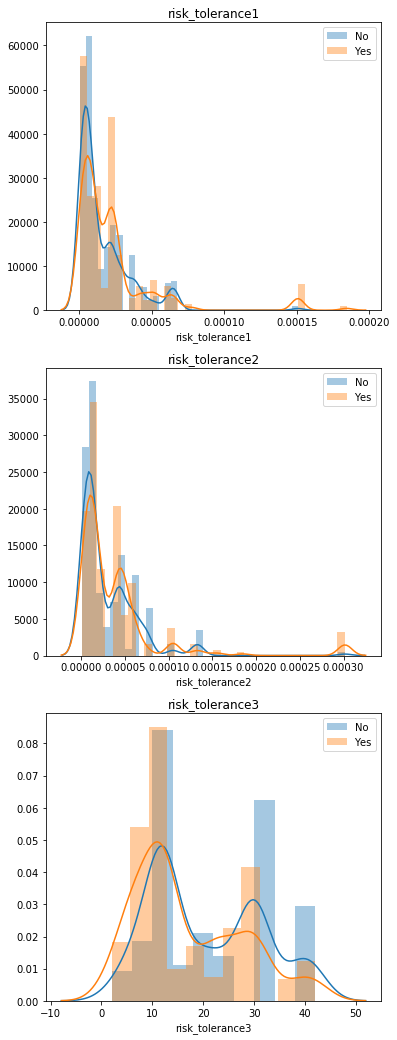

In [57]:
fe['risk_tolerance1'] = (fe.author_years_sen + 1) / fe.author_party / fe.author_total_funding
fe['risk_tolerance2'] = (fe.author_years_sen + 1) * (fe.author_is_chair + 1) / fe.author_party / fe.author_total_funding 
fe['risk_tolerance3'] = (fe.author_years_sen + 1) * (fe.author_is_chair + 1)
print_histograms(fe, ['risk_tolerance1', 'risk_tolerance2', 'risk_tolerance3'])

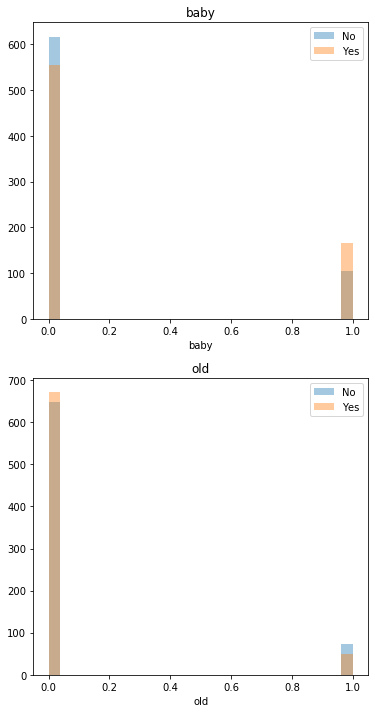

In [92]:
fe['baby'] = fe.author_years_sen.map(lambda x: 1 if x < 5 else 0)
fe['old'] = fe.author_years_sen.map(lambda x: 1 if x > 18 else 0)
print_histograms(fe, ['baby', 'old'], False)

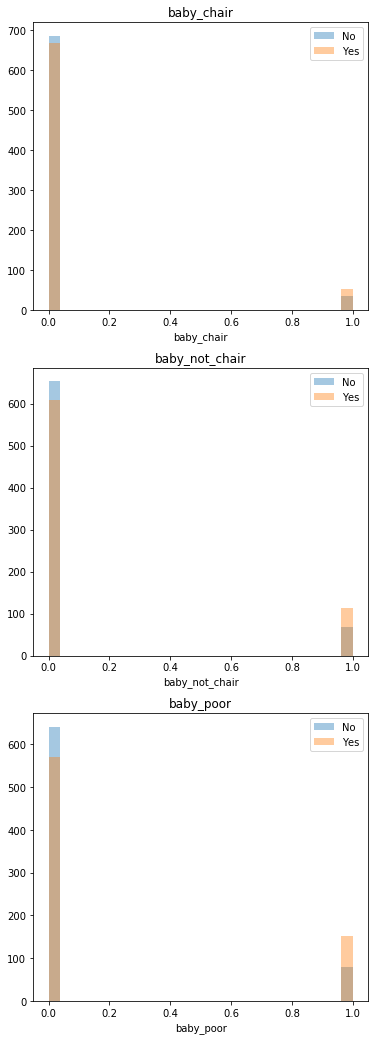

In [98]:
fe['baby_chair'] = fe.apply(lambda x: 1 if x.author_years_sen < 5 and x.author_is_chair > 0 else 0, axis=1)
fe['baby_not_chair'] = fe.apply(lambda x: 1 if x.author_years_sen < 5 and x.author_is_chair < 1 else 0, axis=1)
fe['baby_poor'] = fe.apply(lambda x: 1 if x.author_years_sen < 5 and x.author_total_funding < .2*10**7 else 0, axis=1)
print_histograms(fe, ['baby_chair', 'baby_not_chair', 'baby_poor'], False)

**Hard to make author data really separate bill success**

# Non-Author Data

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


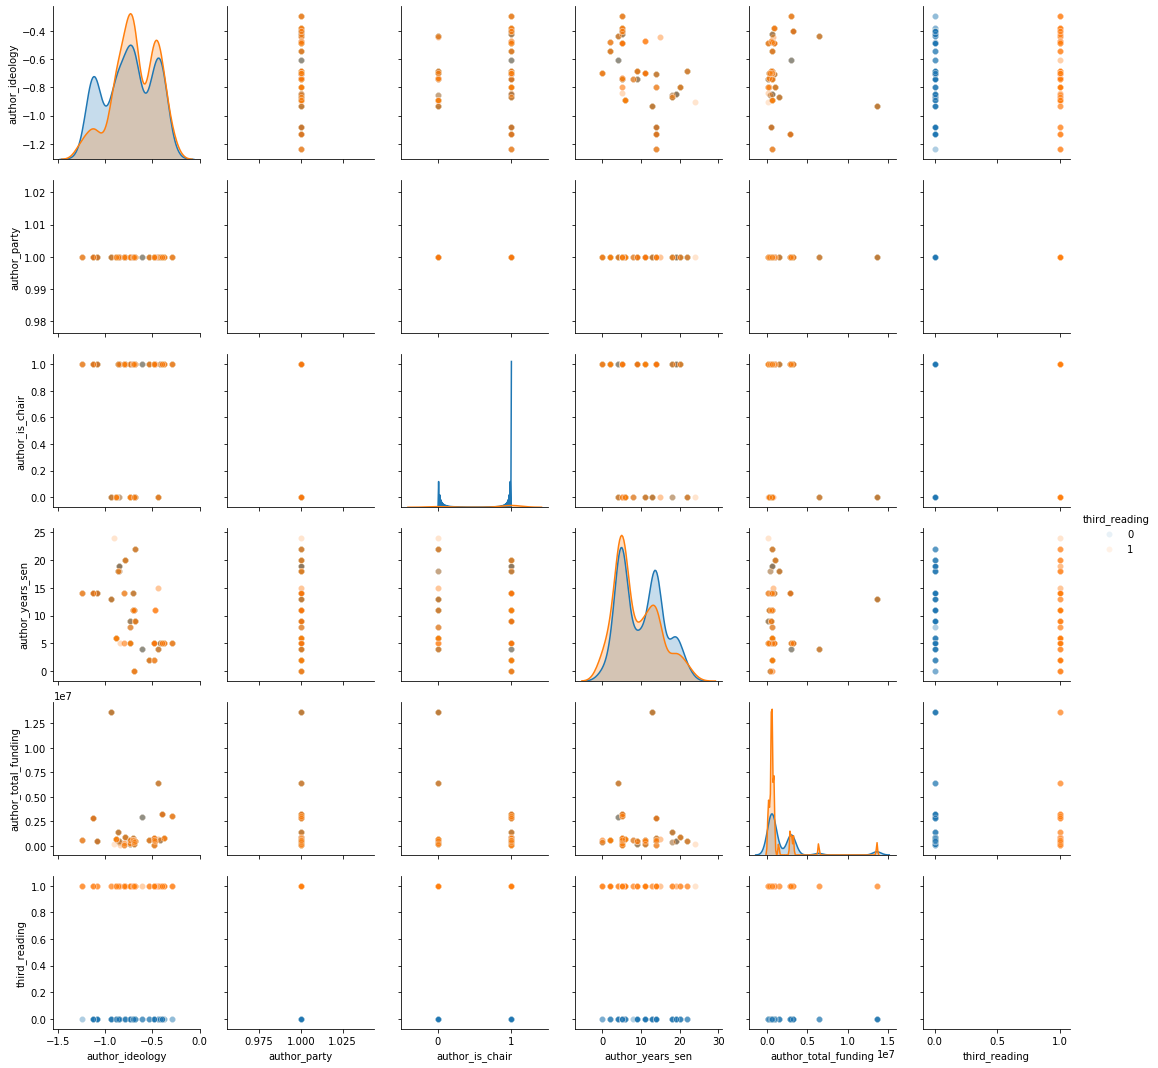

In [46]:
author_features = [
    'author_ideology',
    'author_party',
    'author_is_chair',
    'author_years_sen',
    'author_total_funding',
    'third_reading'
#     'total_sponsors',
#     'sponsor_chairs',
#     'agg_funding_sponsors',
#     'agg_exp_sponsors',
#     'total_slips',
#     'slips_perc_pro',
# #     'bipartisan',
#     'ideol_range',
]

sns.pairplot(normal_os[normal_os.author_party == 1][author_features], hue='third_reading', plot_kws={'alpha': 0.1})

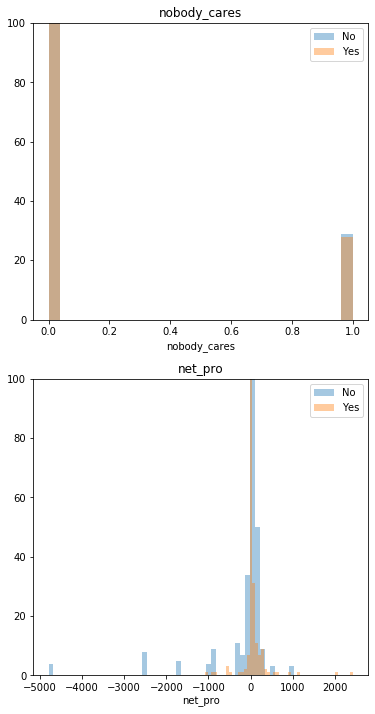

In [108]:
fe['nobody_cares'] = fe.apply(lambda x: 1 if x.total_slips <1 and x.total_sponsors < 1 else 0, axis=1)
fe['net_pro'] = (fe.slips_perc_pro * fe.total_slips) - ((1-fe.slips_perc_pro) * fe.total_slips)
print_histograms(fe, ['nobody_cares', 'net_pro'], kde=False, y_lim=100)
# net pro might be ok

# Standardize It

In [37]:
features_to_standardize = [
    'author_ideology',
#     'author_party',
#     'author_is_chair',
    'author_years_sen',
    'author_total_funding',
    'total_sponsors',
    'sponsor_chairs',
    'agg_funding_sponsors',
    'agg_exp_sponsors',
    'total_slips',
    'slips_perc_pro',
#     'bipartisan',
    'ideol_range',
]

norm_std = normal_data.copy()
norm_std.loc[:, features_to_standardize] = StandardScaler().fit_transform(normal_data[features_to_standardize])
norm_std = pd.DataFrame(norm_std, columns=first_feature_set)
norm_std['third_reading'] = normal_data.third_reading

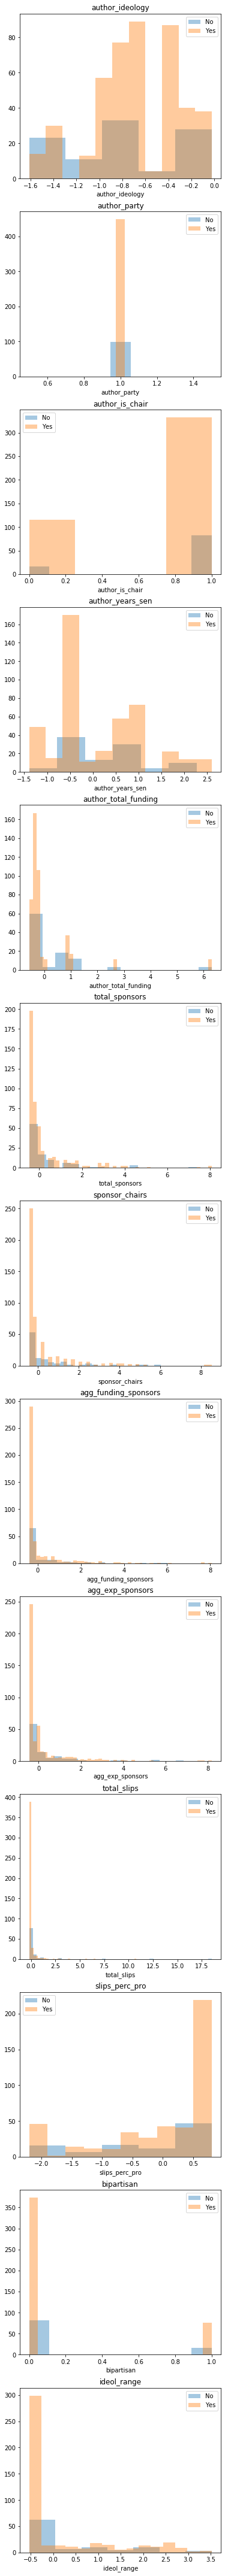

In [39]:
print_histograms(norm_std[norm_std.author_party == 1], first_feature_set, kde=False)

In [40]:
ros = RandomOverSampler(random_state=0)
std_os, std_os_y = ros.fit_sample(norm_std.drop(columns=['third_reading']), norm_std['third_reading'])
std_os = pd.DataFrame(normal_os, columns=[x for x in norm_std.columns if x != 'third_reading'])
std_os['third_reading'] = std_os_y

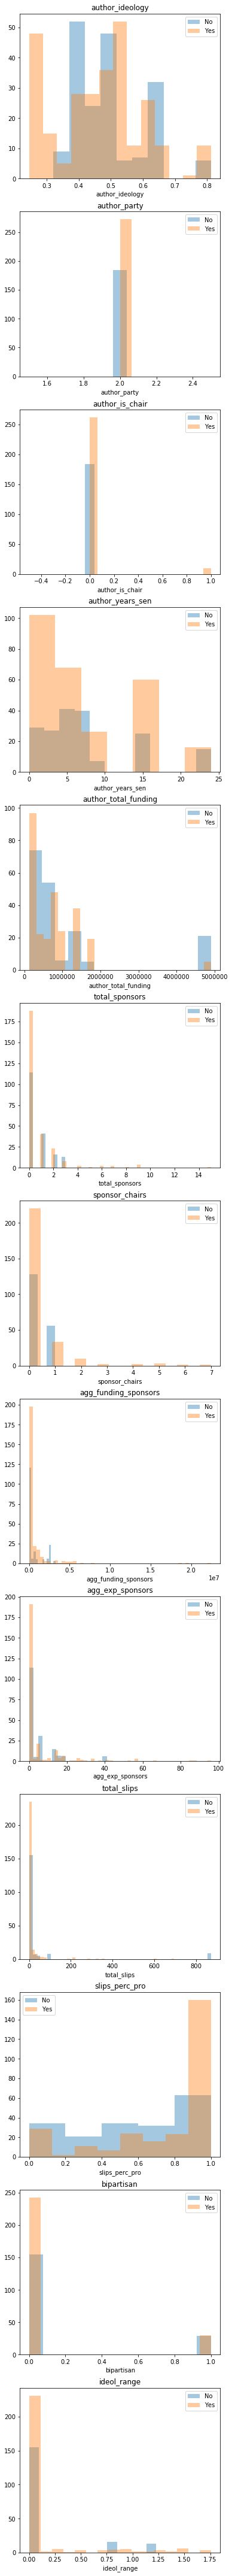

In [44]:
print_histograms(std_os[std_os.author_party == 2], first_feature_set, kde=False)

# What if I modeled the parties separately?

In [49]:
normal_data[normal_data.author_party == 2].shape

(305, 25)

# Features to Keep

In [ ]:
fe['net_pro'] = (fe.slips_perc_pro * fe.total_slips) - ((1-fe.slips_perc_pro) * fe.total_slips)

In [ ]:
fe['risk_tolerance3'] = (fe.author_years_sen + 1) * (fe.author_is_chair + 1)

In [ ]:
fe['has_slips'] = fe.total_slips.map(lambda x: 1 if x > 0 else 0)

In [ ]:
fe['unanimous_slips'] = fe.slips_perc_pro.map(lambda x: 1 if x > 0 else 0)

# Just Democrats

## Author Transformations

### Funding

In [139]:
dem_data = normal_os[normal_os.author_party == 1]

In [141]:
dem_data.head()

,bill_id,author_id,author_ideology,author_party,author_is_chair,author_years_sen,author_total_funding,total_sponsors,dem_sponsors,rep_sponsors,...,agg_exp_sponsors,total_slips,pro_slips,opp_slips,no_pos_slips,slips_perc_pro,bipartisan,ideol_range,first_word_approp,third_reading
0,907435,14317,-0.482,1,1,5,839542,1,0,1,...,5,3,3,0,0,1,0,0,0,1
1,907471,14317,-0.482,1,1,5,839542,0,0,0,...,0,3,3,0,0,1,0,0,0,1
2,907494,14323,-0.484,1,1,5,114458,5,5,0,...,49,10,9,1,0,0.9,0,0.542,0,1
3,907529,14314,-0.296,1,1,5,3.01936e+06,2,2,0,...,10,25,21,3,1,0.84,0,0.043,0,1
4,907556,1069,-0.738,1,1,9,150725,2,2,0,...,19,7,5,2,0,0.714286,0,0.046,0,1


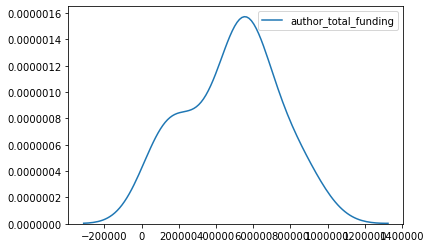

In [155]:
d = dem_data[(dem_data.author_total_funding < 1000000)].groupby('author_id').author_total_funding.agg('mean').reset_index()
sns.kdeplot(d.author_total_funding);
# plt.gca().set_xlim([0, 4000000])

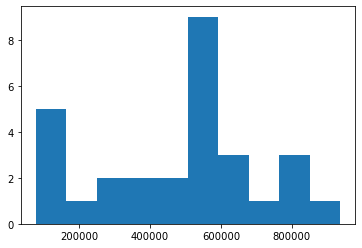

In [156]:
plt.hist(d.author_total_funding, bins=10);

In [157]:
# funding thresholds, < 400,000; < 1 mil, more than 1 mil
dem_data['funding_level'] = dem_data.author_total_funding.map(lambda x: 0 if float(x) < 400000 else 1 if x < 1000000 else 2)


/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


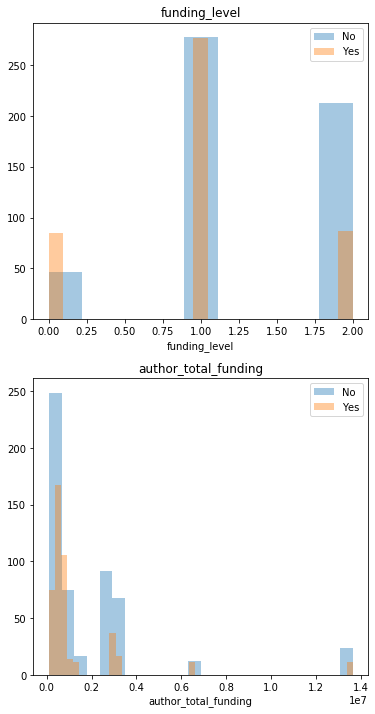

In [158]:
print_histograms(dem_data, ['funding_level', 'author_total_funding'], kde=False)

In [90]:
fe.funding_level.value_counts()

1    555
2    300
0    131
Name: funding_level, dtype: int64

### Experience

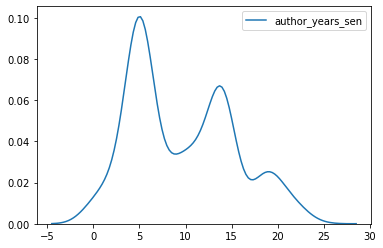

In [159]:
sns.kdeplot(dem_data.author_years_sen);

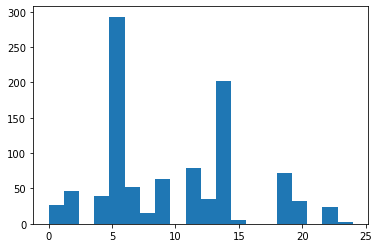

In [160]:
plt.hist(dem_data.author_years_sen, bins=20);

In [ ]:
# sensible buckets -> less than 5, 5 to 10, 10 to 15, more than 15

In [207]:
dem_data['author_term'] = dem_data.author_years_sen.map(lambda x: 3 if (np.floor(x / 5) + 1) > 3 else np.floor(x / 5) + 1)
# dem_data['num_terms'] = dem_data.author_years_sen.map(lambda x: np.floor(x / 4) if np.floor(x / 4) < 4 else 3)
# dem_data['first_term'] = dem_data.author_years_sen.map(lambda x: 1 if x < 4 else 0)

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


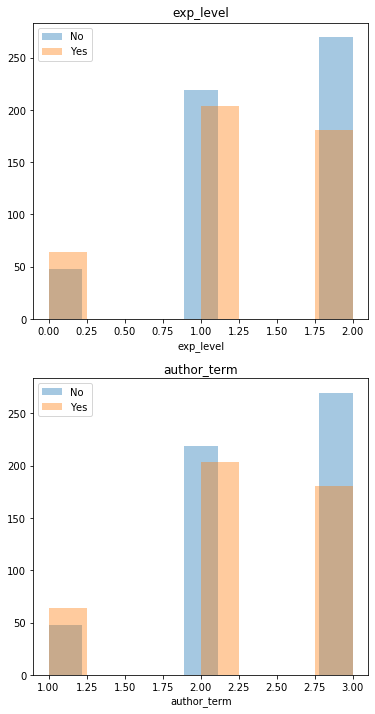

In [208]:
print_histograms(dem_data, ['exp_level', 'author_term'], kde=False)

### Ideology

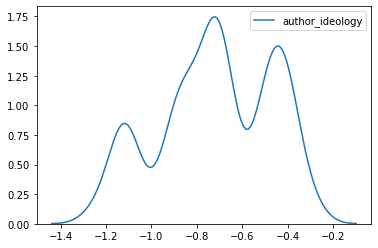

In [165]:
sns.kdeplot(dem_data.author_ideology);

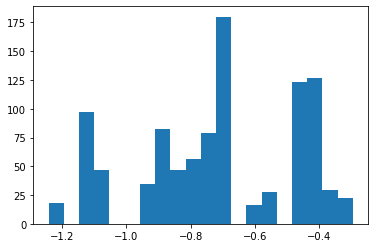

In [167]:
plt.hist(dem_data.author_ideology, bins=20);

In [178]:
dem_data.author_ideology = dem_data.author_ideology.astype(float)
dem_data['very_liberal'] = dem_data.author_ideology.map(lambda x: 1 if x < -1 else 0)


/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


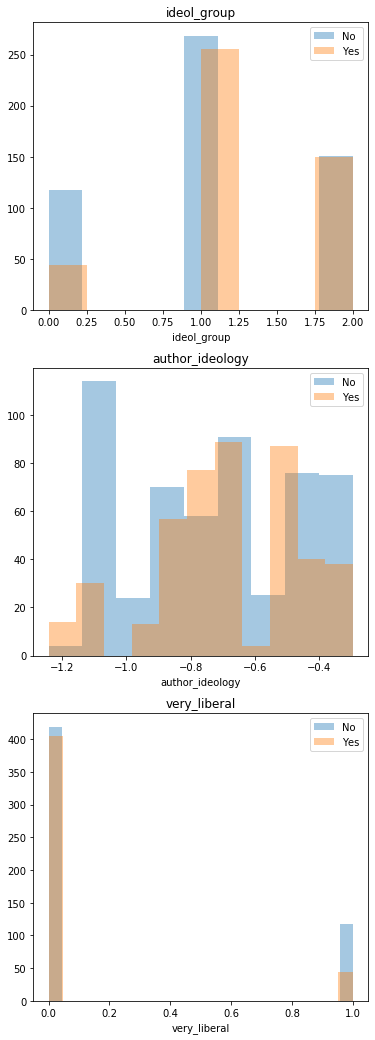

In [179]:
print_histograms(dem_data, ['ideol_group', 'author_ideology', 'very_liberal'], kde=False)